# Human in the loop

In [ ]:
pip install langchain_groq

In [ ]:
from langchain_groq import ChatGroq

In [ ]:
import os
from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = "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" # Replace with your actual API key

llm=ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

In [ ]:
pip install langchain_tavily

In [ ]:
pip install langgraph

In [ ]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

In [ ]:
# Replace with your actual Tavily API key
os.environ["TAVILY_API_KEY"] = "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"

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.

    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [ ]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

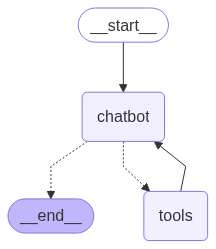

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
user_input = "I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (vscxmrxn4)
 Call ID: vscxmrxn4
  Args:
    query: building an AI agent


In [ ]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (vscxmrxn4)
 Call ID: vscxmrxn4
  Args:
    query: building an AI agent
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
